In [8]:
import logging
import os
import sys
from pathlib import Path
import torch
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
from torch.utils.data import DataLoader
from collections import OrderedDict
base_path = Path(fr"C:\Users\devil\Downloads\FL_AV\my-project\data\bdd100_batch/batch_3/train")

# Lock file to prevent duplicate assignments
lock_file = base_path / ".lock"

In [9]:
if lock_file.exists():
    lock_file.unlink()
    print(f"Lock file removed for batch .")

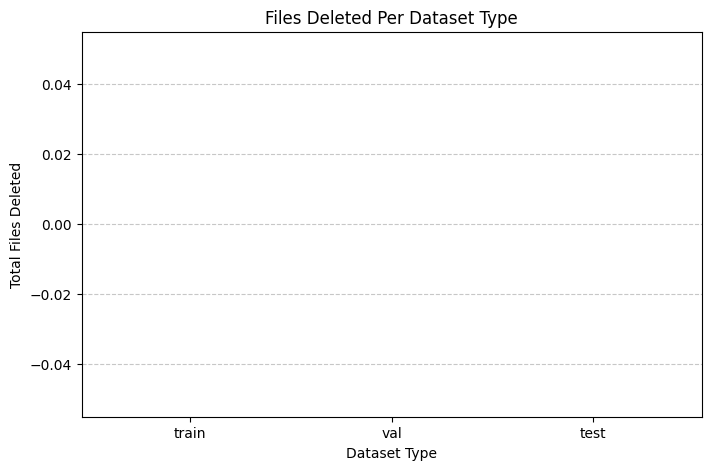


Cleanup Completed! Check 'bdd_dataset_cleanup_final.log' for details.


In [ ]:
import json
import os
import logging
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(
    filename="logs\data_100k\bdd_dataset_cleanup_final.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Paths for Train, Val, and Test
bdd_annotations_paths = {
    "train": r"C:\Users\devil\Downloads\FL_AV\data\bdd100k\label_json\det_train.json",
    "val": r"C:\Users\devil\Downloads\FL_AV\data\bdd100k\label_json\det_val.json",
}

image_folders = {
    "train": r"C:\Users\devil\Downloads\FL_AV\data\bdd100k\images\train",
    "val": r"C:\Users\devil\Downloads\FL_AV\data\bdd100k\images\val",
    "test": r"C:\Users\devil\Downloads\FL_AV\data\bdd100k\images\test",  # Only check for presence in train/val
}

# Load valid image names from JSON (store full filenames including extensions)
def load_valid_image_names(json_path):
    try:
        with open(json_path, "r") as file:
            data = json.load(file)

            # Store full filenames exactly as they appear in JSON (with extension)
            return {entry["name"].strip().lower() for entry in data}  

    except (FileNotFoundError, json.JSONDecodeError, PermissionError) as e:
        logging.error(f"Error loading JSON file {json_path}: {e}")
        return None

# Delete images that are NOT in the valid names list
def clean_directory(valid_image_names, directory, dataset_type):
    if not os.path.exists(directory):
        logging.warning(f"Directory not found: {directory}")
        return 0

    total_deleted = 0
    try:
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)

            # Normalize name format (full filename including extension)
            normalized_name = file_name.strip().lower()

            # Skip non-image files
            if not file_name.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            # Delete file if full filename is NOT in JSON
            if normalized_name not in valid_image_names:
                try:
                    os.remove(file_path)
                    logging.info(f"Deleted {file_path} (not found in {dataset_type}.json)")
                    total_deleted += 1
                except PermissionError as e:
                    logging.error(f"Permission error deleting {file_path}: {e}")

    except Exception as e:
        logging.error(f"Error processing directory {directory}: {e}")

    logging.info(f"Total files deleted in {dataset_type}: {total_deleted}")
    return total_deleted

# Delete test images if they exist in train or val
def clean_test_directory(train_valid_names, val_valid_names, test_directory):
    if not os.path.exists(test_directory):
        logging.warning(f"Test directory not found: {test_directory}")
        return 0

    total_deleted = 0
    try:
        for file_name in os.listdir(test_directory):
            file_path = os.path.join(test_directory, file_name)

            # Normalize name format (full filename including extension)
            normalized_name = file_name.strip().lower()

            # Skip non-image files
            if not file_name.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            # Delete test images if found in train or val
            if normalized_name in train_valid_names or normalized_name in val_valid_names:
                try:
                    os.remove(file_path)
                    logging.info(f"Deleted {file_path} (found in train/val.json)")
                    total_deleted += 1
                except PermissionError as e:
                    logging.error(f"Permission error deleting {file_path}: {e}")

    except Exception as e:
        logging.error(f"Error processing test directory {test_directory}: {e}")

    logging.info(f"Total files deleted in test: {total_deleted}")
    return total_deleted

# Main execution
if __name__ == "__main__":
    dataset_deletions = {}

    # Load valid train and val image names
    valid_train_names = load_valid_image_names(bdd_annotations_paths["train"])
    valid_val_names = load_valid_image_names(bdd_annotations_paths["val"])

    if valid_train_names is None or valid_val_names is None:
        logging.error("Error loading JSON files. Exiting...")
        print("Error loading JSON files. Check log for details.")
        exit()

    # Clean train (check train.json)
    dataset_deletions["train"] = clean_directory(valid_train_names, image_folders["train"], "train")

    # Clean val (check val.json)
    dataset_deletions["val"] = clean_directory(valid_val_names, image_folders["val"], "val")

    # Clean test (Delete if present in train or val)
    dataset_deletions["test"] = clean_test_directory(valid_train_names, valid_val_names, image_folders["test"])

    # Visualization
    dataset_names = list(dataset_deletions.keys())
    deleted_counts = list(dataset_deletions.values())

    plt.figure(figsize=(8, 5))
    plt.bar(dataset_names, deleted_counts, color=["blue", "orange", "green"])
    plt.xlabel("Dataset Type")
    plt.ylabel("Total Files Deleted")
    plt.title("Files Deleted Per Dataset Type")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Save and display
    plt.savefig("bdd_dataset_cleanup_summary_final.png")
    plt.show()

    # Summary Log
    logging.info("==== Summary of Deletions ====")
    for dataset_type, deleted_count in dataset_deletions.items():
        logging.info(f"{dataset_type.upper()} - Total Deleted: {deleted_count}")

    print("\nCleanup Completed! Check 'logs\data_100k\bdd_dataset_cleanup_final.log' for details.")
